In [86]:
import pandas as pd
train=pd.read_csv("/kaggle/input/cartoon-emotion-detection/Train.csv")
test=pd.read_csv("/kaggle/input/cartoon-emotion-detection/Test.csv")
train[:10]

Frame_ID    Emotion
0  frame0.jpg      happy
1  frame1.jpg      happy
2  frame2.jpg  surprised
3  frame3.jpg  surprised
4  frame4.jpg      angry
5  frame5.jpg  surprised
6  frame6.jpg  surprised
7  frame7.jpg  surprised
8  frame8.jpg  surprised
9  frame9.jpg      angry

In [2]:
import cv2
import os

def extract_frames(video_path, output_folder, fps=1):
    os.makedirs(output_folder, exist_ok=True)
    cap=cv2.VideoCapture(video_path)
    video_fps=int(cap.get(cv2.CAP_PROP_FPS)) 
    frame_interval=video_fps // fps 
    frame_count=0
    image_count=0
    while cap.isOpened():
        ret, frame=cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frame_filename=os.path.join(output_folder, f"frame {image_count:05d}.jpg")
            cv2.imwrite(frame_filename, frame)
            image_count += 1
        frame_count += 1
    cap.release()
    print(f"Extracted {image_count} frames at {fps} FPS.")
video_path="/kaggle/input/cartoon-emotion-detection/Train Tom and jerry.mp4" 
output_folder="extracted_frames"
extract_frames(video_path, output_folder, fps=1) 

Extracted 298 frames at 1 FPS.


In [3]:
test_videopath='/kaggle/input/cartoon-emotion-detection/Test Tom and Jerry.mp4'
output_folder="test_extracted_frames"
extract_frames(video_path, output_folder, fps=1)

Extracted 298 frames at 1 FPS.


In [15]:
def convert_to_actual_filename(frame_id):
    frame_number=frame_id.replace('frame', '').replace('.jpg', '').zfill(5)  # Ensures 5 digits with leading zeros
    return f"frame {frame_number}.jpg"

train['Full_Path']=train['Frame_ID'].apply(lambda x: os.path.join('/kaggle/working/extracted_frames', convert_to_actual_filename(x)))

In [87]:
def test_conv(frame_id):
  frame_number=frame_id.replace('test', '').replace('.jpg', '').zfill(5)  # Ensures 5 digits with leading zeros
  return f"frame {frame_number}.jpg"
test['FUll_Path']=test['Frame_ID'].apply(lambda x: os.path.join('/kaggle/working/test_extracted_frames', test_conv(x)))

In [8]:
import plotly.express as px
counts_=train['Emotion'].value_counts().reset_index()
fig=px.bar(counts_, x='Emotion', y='count')
fig.show()

In [10]:
HEIGHT=224
WIDTH=224

In [23]:
def total_percentage(data):
  total=sum(data.values)
  return [f'{value/total:.2%}' for value in data.values]
print(total_percentage(train.Emotion.value_counts()))

['38.93%', '22.82%', '13.42%', '12.42%', '12.42%']


In [11]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import  LabelEncoder
import numpy as np
y_train=train['Emotion']
label_encoder=LabelEncoder()
y_train_encoded=label_encoder.fit_transform(y_train)
class_weights=compute_class_weight("balanced", classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weights=dict(enumerate(class_weights))
print("Class Weights:", class_weights)
print("Label Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

Class Weights: {0: 0.5137931034482759, 1: 1.6108108108108108, 2: 1.6108108108108108, 3: 1.49, 4: 0.8764705882352941}
Label Mapping: {'Unknown': 0, 'angry': 1, 'happy': 2, 'sad': 3, 'surprised': 4}


In [19]:
import tensorflow as tf

def load_image(filename, label=None):
    image=tf.io.read_file(filename) 
    image=tf.image.decode_jpeg(image, channels=3)  
    image=tf.image.resize(image, (224, 224)) 
    image=image / 255.0 
    if label is None:
        return image
    else:
        return image, label

labels=train['Emotion'].values
label_map={'Unknown': 0, 'angry': 1, 'happy': 2, 'sad': 3, 'surprised': 4}
encoded_labels=[label_map[label] for label in labels]
num_classes=len(label_map)
one_hot_labels=tf.keras.utils.to_categorical(encoded_labels, num_classes=num_classes)

file_paths=train['Full_Path'].values

train_ds=tf.data.Dataset.from_tensor_slices((file_paths[:238], one_hot_labels[:238]))
train_ds=train_ds.map(load_image)
train_ds=train_ds.shuffle(1000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

val_ds=tf.data.Dataset.from_tensor_slices((file_paths[239:], one_hot_labels[239:]))
val_ds=val_ds.map(load_image)
val_ds=val_ds.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [20]:
test_ds=tf.data.Dataset.from_tensor_slices(test['FUll_Path'].values)
test_ds=test_ds.map(load_image)
test_ds=test_ds.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

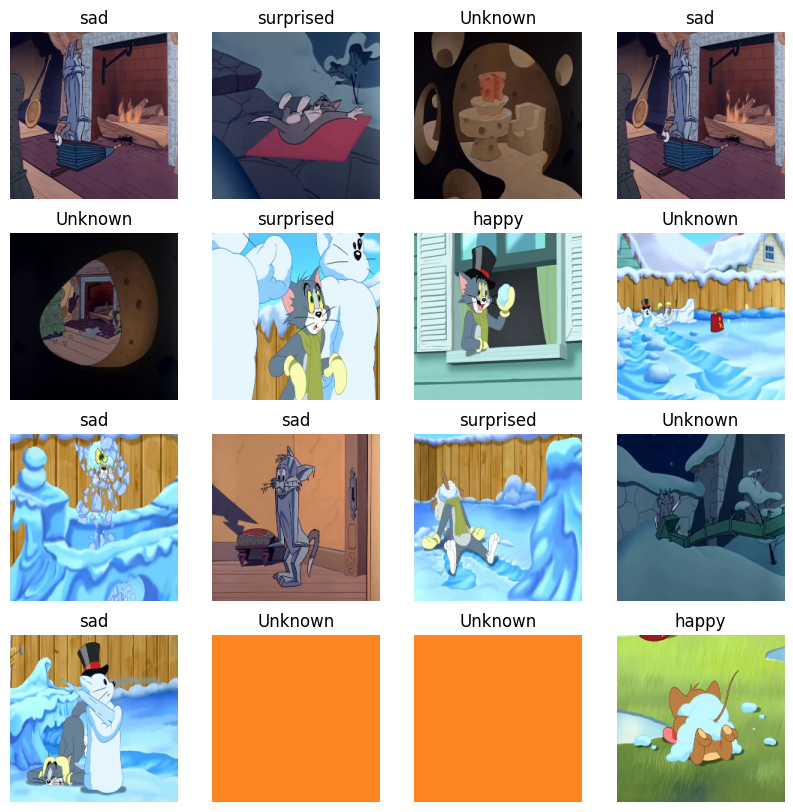

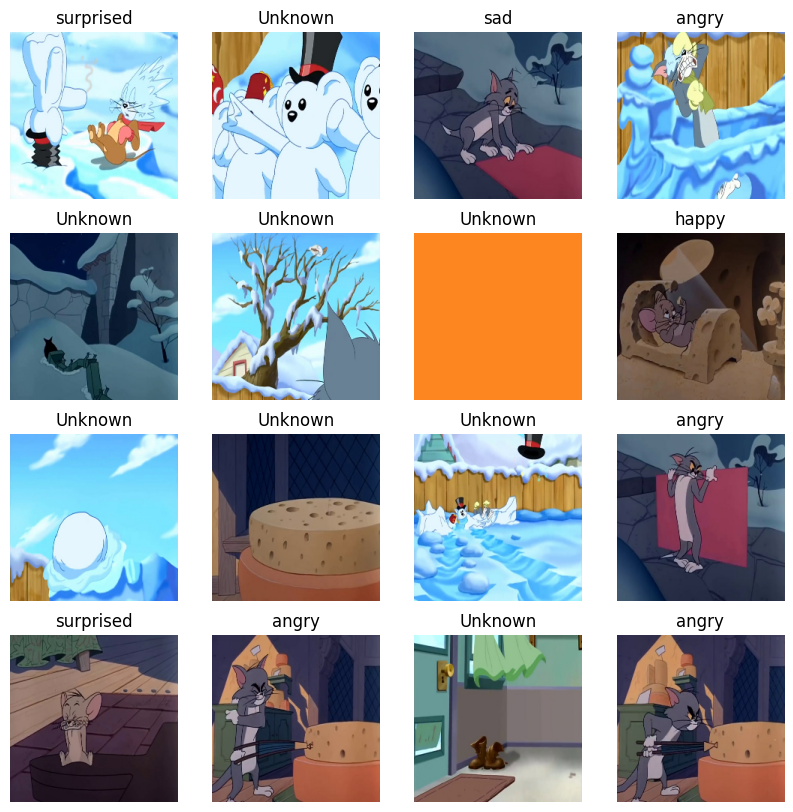

In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt

def label_decoder(i):
    i=tf.where(i == 1)
    i=i.numpy().flatten()[0]
    labels=['Unknown','angry','happy', 'sad', 'surprised']
    return labels[i] 

def visualize_data(data, label=None):
    fig, axes=plt.subplots(4, 4, figsize=(10, 10))
    for i in range(4):
        for j in range(4):
            axes[i, j].imshow(data[i * 4 + j])
            if label is not None:
              axes[i, j].set_title(label_decoder(label[i * 4 + j]))
            axes[i, j].axis('off')
    plt.show()

# Assuming train_ds is a TensorFlow dataset
for i, j in train_ds.take(2):
    visualize_data(i.numpy(), j.numpy())  # Convert tensors to NumPy before passing

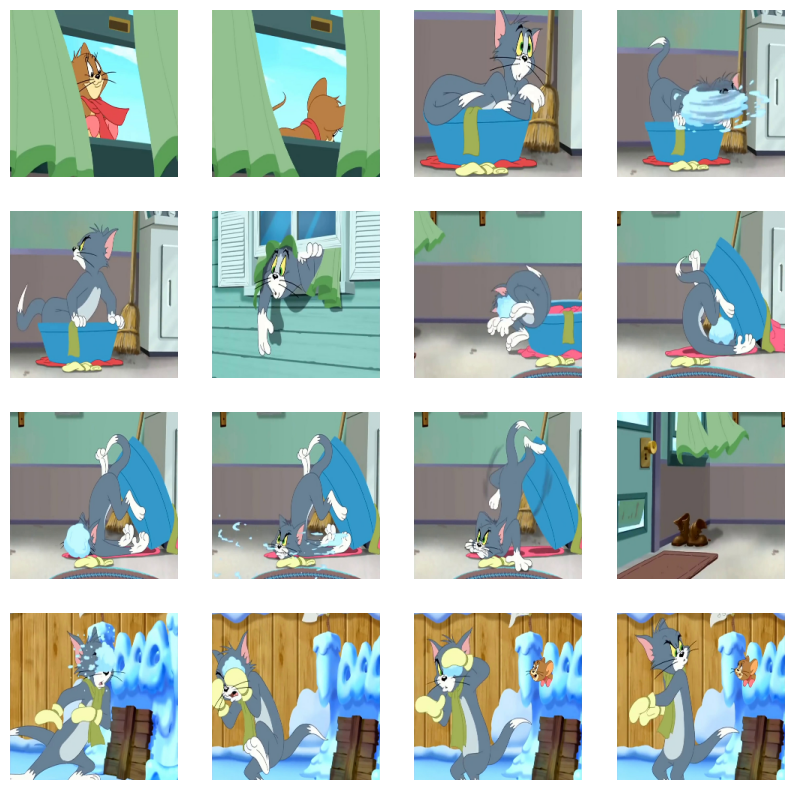

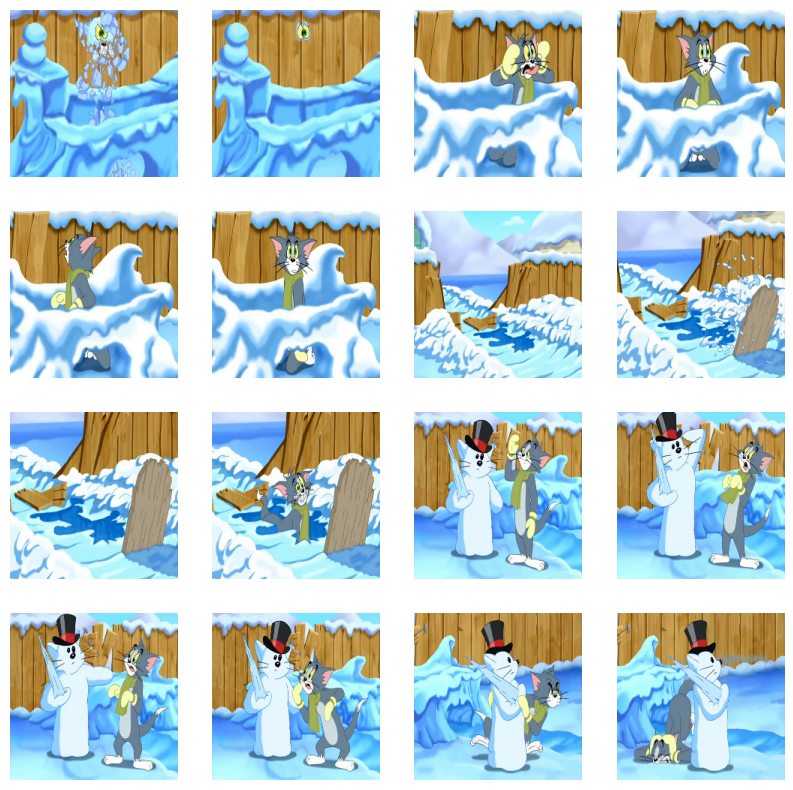

In [47]:
for i in test_ds.take(2):
  visualize_data(i.numpy())

In [24]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

def compute_gradcam(model, image, class_idx, layer_name="conv5_block3_out"):
    grad_model=tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, predictions=grad_model(tf.expand_dims(image, axis=0))  
        loss=predictions[:, class_idx]  
    grads=tape.gradient(loss, conv_output)
    pooled_grads=tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap=tf.reduce_sum(pooled_grads * conv_output, axis=-1)[0]  
    heatmap=np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

def overlay_gradcam(image, heatmap, alpha=0.4):
    heatmap=cv2.resize(heatmap, (image.shape[1], image.shape[0]))  # Resize to match image
    heatmap=np.uint8(255 * heatmap)  # Convert to 0-255
    heatmap=cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply colormap
    overlay=cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)  # Blend images
    return overlay
def show_gradcam(model, image, class_idx, layer_name="conv5_block3_out"):
    heatmap=compute_gradcam(model, image, class_idx, layer_name)
    overlay=overlay_gradcam((image.numpy() * 255).astype("uint8"), heatmap)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image.numpy())
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Grad-CAM Heatmap")
    plt.show()


In [25]:
import tensorflow as tf
from tensorflow.keras import backend as K

class MultiClassMacroF1(tf.keras.metrics.Metric):
    def __init__(self, name="multi_class_macro_f1", num_classes=3, **kwargs):
        super(MultiClassMacroF1, self).__init__(name=name, **kwargs)
        self.num_classes=num_classes
        self.true_positives=self.add_weight(name="tp", shape=(num_classes,), initializer="zeros")
        self.false_positives=self.add_weight(name="fp", shape=(num_classes,), initializer="zeros")
        self.false_negatives=self.add_weight(name="fn", shape=(num_classes,), initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true=tf.argmax(y_true, axis=1)  
        y_pred=tf.argmax(y_pred, axis=1)
        for i in range(self.num_classes):
            true_mask=tf.equal(y_true, i)
            pred_mask=tf.equal(y_pred, i)
            tp=tf.reduce_sum(tf.cast(tf.logical_and(true_mask, pred_mask), tf.float32))
            fp=tf.reduce_sum(tf.cast(tf.logical_and(tf.logical_not(true_mask), pred_mask), tf.float32))
            fn=tf.reduce_sum(tf.cast(tf.logical_and(true_mask, tf.logical_not(pred_mask)), tf.float32))
            self.true_positives.assign_add(tf.tensor_scatter_nd_add(self.true_positives, [[i]], [tp]))
            self.false_positives.assign_add(tf.tensor_scatter_nd_add(self.false_positives, [[i]], [fp]))
            self.false_negatives.assign_add(tf.tensor_scatter_nd_add(self.false_negatives, [[i]], [fn]))
    def result(self):
        precision=self.true_positives / (self.true_positives + self.false_positives + K.epsilon())
        recall=self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())
        f1=2 * (precision * recall) / (precision + recall + K.epsilon())
        return tf.reduce_mean(f1)  # Macro F1 Score
    def get_tp_fp_fn(self):
        return {
            "TP": self.true_positives.numpy(),
            "FP": self.false_positives.numpy(),
            "FN": self.false_negatives.numpy()
        }

    def reset_states(self):
        K.batch_set_value([(v, tf.zeros_like(v)) for v in self.variables])

In [26]:
import tensorflow as tf
base_model=tf.keras.applications.ResNet50(weights=None,input_shape=(224,224,3),classes=5)
base_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy", MultiClassMacroF1(num_classes=5)]
)

In [31]:
history=base_model.fit(x=train_ds,
                    epochs=50,
                    class_weight=class_weights,
                    validation_data=val_ds)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.8779 - loss: 0.4194 - multi_class_macro_f1: 0.9479 - val_accuracy: 0.0169 - val_loss: 4.8046 - val_multi_class_macro_f1: 0.0118
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.8749 - loss: 0.3980 - multi_class_macro_f1: 0.8954 - val_accuracy: 0.3051 - val_loss: 5.0740 - val_multi_class_macro_f1: 0.0494
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.8503 - loss: 0.3949 - multi_class_macro_f1: 0.9236 - val_accuracy: 0.3729 - val_loss: 3.8118 - val_multi_class_macro_f1: 0.0952
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.8872 - loss: 0.3040 - multi_class_macro_f1: 0.9099 - val_accuracy: 0.4237 - val_loss: 3.9691 - val_multi_class_macro_f1: 0.1033
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.9342 - loss: 0.2578 - multi_class_macro_f1: 0.9726 - val_accuracy: 0.4746 - val_loss: 4.0149 - val_multi_class_macro_f1: 0.1196
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


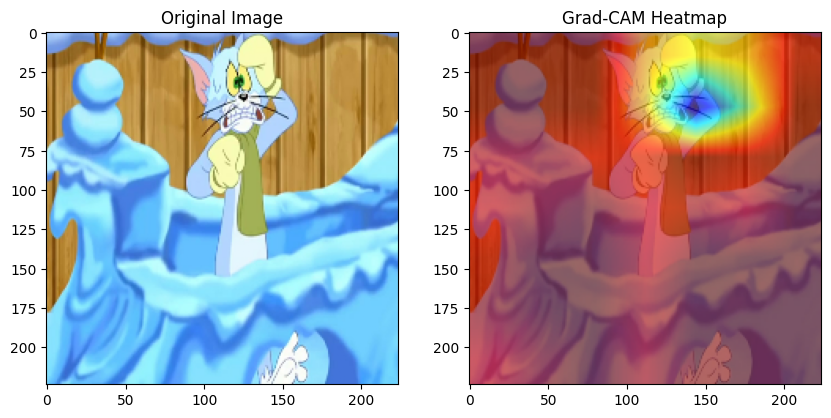

Predicted Class: 3
Predictions: [[0.04839503 0.02363594 0.12214401 0.5304483  0.27537677]]


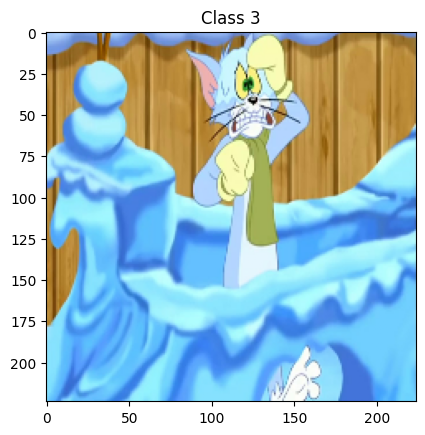

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


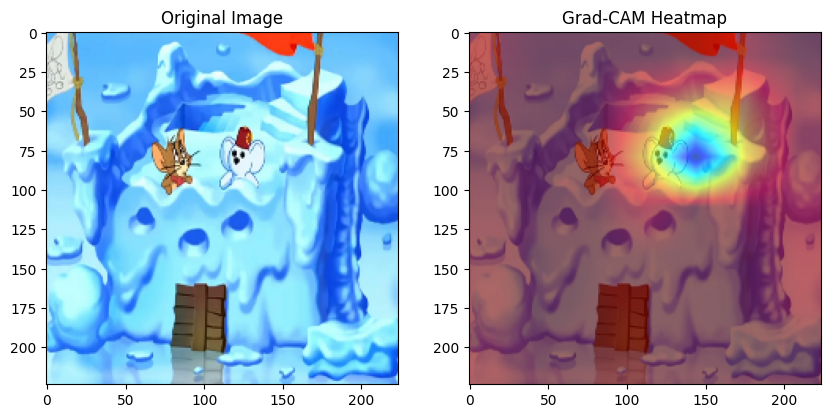

Predicted Class: 3
Predictions: [[0.09411541 0.0499281  0.36540422 0.4825734  0.00797881]]


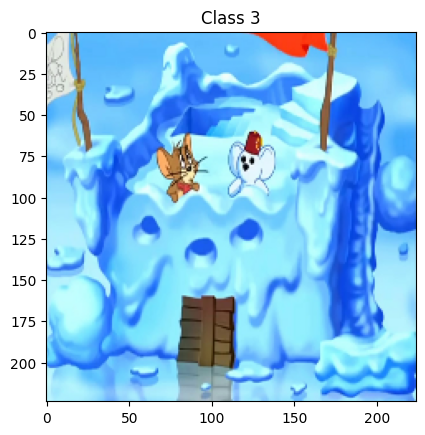

In [48]:
for i in test_ds.take(2):
    image=i[31]  # Extract the first image
    image=tf.expand_dims(image, axis=0)  # Ensure batch dimension -> (1, 224, 224, 3)

    predictions=base_model.predict(image)
    class_idx=np.argmax(predictions)

    show_gradcam(base_model, image[0], class_idx=class_idx, layer_name="conv5_block3_out")

    print("Predicted Class:", class_idx)
    print("Predictions:", predictions)

    plt.imshow(image[0])  # Remove unnecessary indexing
    plt.title(f"Class {class_idx}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


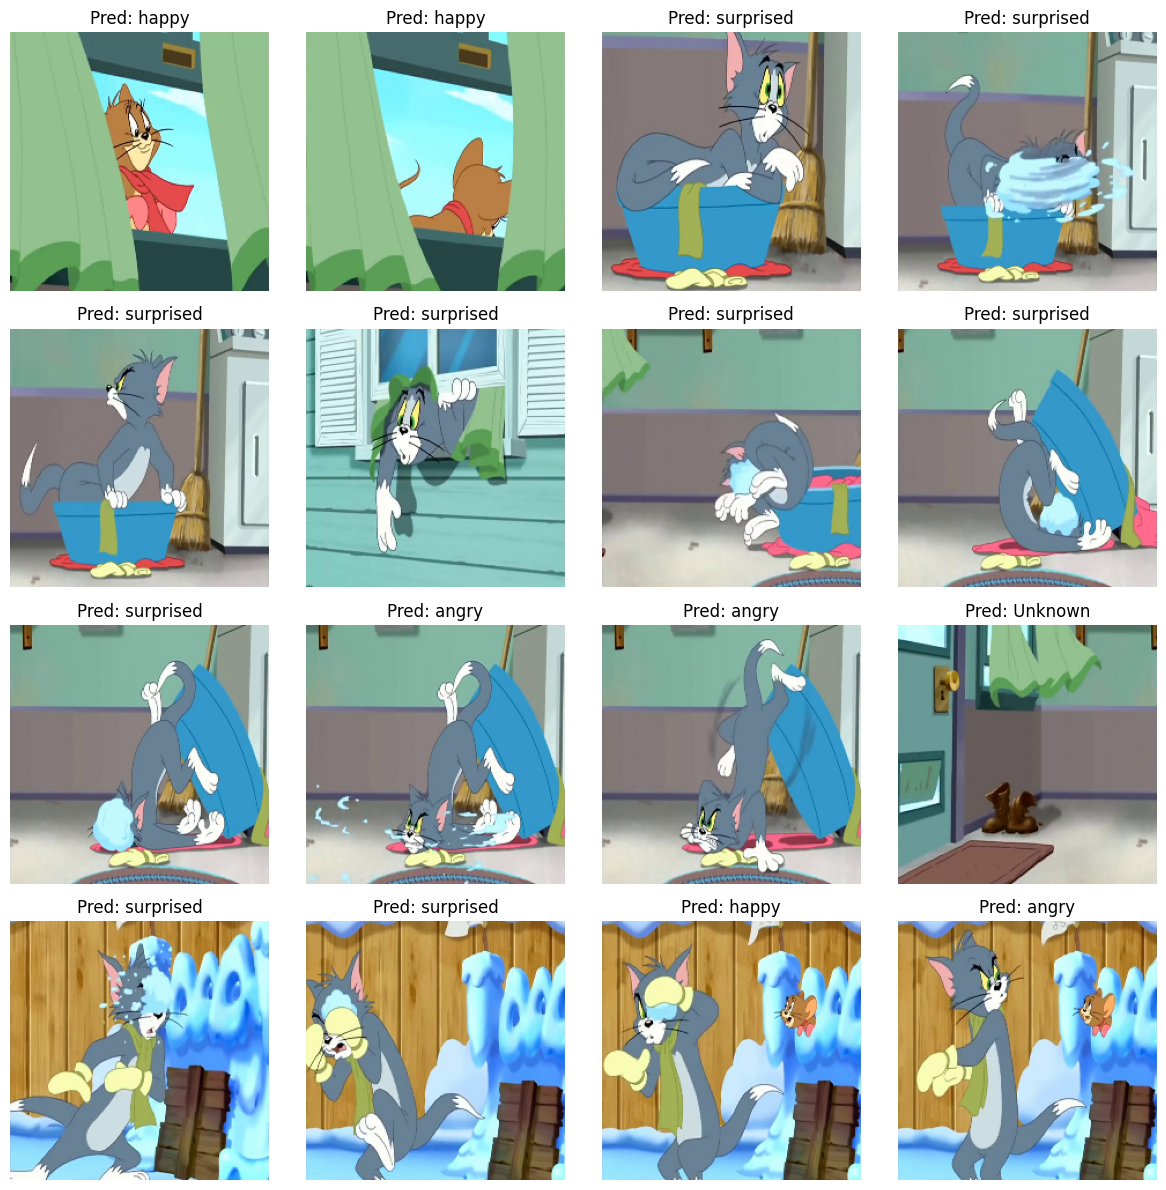

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Class labels mapping
class_labels={0: 'Unknown', 1: 'angry', 2: 'happy', 3: 'sad', 4: 'surprised'}

# Store test images and predictions
test_images=[]
test_preds=[]

for batch in test_ds:
    preds=base_model.predict(batch)  # Predict on batch
    test_images.extend(batch.numpy())  # Convert tensor to numpy
    test_preds.extend(np.argmax(preds, axis=1))  # Get predicted class

# Visualize first 16 images with predictions
plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"Pred: {class_labels[test_preds[i]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [98]:
test_p=[class_labels[i] for i in test_preds]

# Save predictions to CSV
data=pd.DataFrame({'Emotion': test_p})
data.to_csv('/kaggle/working/predictions.csv', index=False,header=True)

print("CSV file saved successfully!")


CSV file saved successfully!


In [88]:
test.drop(['FUll_Path'],axis=1,inplace=True)

In [99]:
test['Emotion']=test_p

In [100]:
test

Frame_ID    Emotion
0      test0.jpg      happy
1      test1.jpg      happy
2      test2.jpg  surprised
3      test3.jpg  surprised
4      test4.jpg  surprised
..           ...        ...
181  test181.jpg      happy
182  test182.jpg      happy
183  test183.jpg      happy
184  test184.jpg      happy
185  test185.jpg    Unknown

[186 rows x 2 columns]

In [101]:
test.to_csv("/kaggle/working/test_p.csv",index=False)
print("CSV file saved successfully!")

CSV file saved successfully!
